# Classification of Malaria-Infected Cells using Amazon SageMaker

## Introduction

In this example Amazon SageMaker image classification algorithm will be used to train on Malaria-Infected cell images.<br>
The steps taken in order to achive fully deployed model are:
- preparation of the dataset (downloading, resizing, converting to .rec file, uploading to S3)
- training model (setting up connection and data channels, choosing training instance, setting up hyperparameters)
- deploying model locally 

## 1.Dataset

Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets. <br>
It contains 13775 images of blood cells infected by malaria:
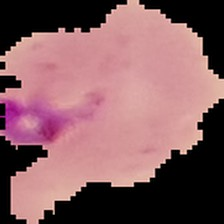 
And 13779 uninfected ones:
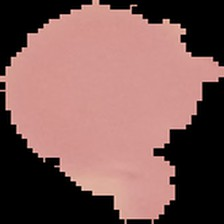
Every cell has different shape and colour varying from pink to purple.
Malaria-causing parasite Plasmodium visible as dark spot appears in many shapes, positions and sizes.
The pictures have different widths and heights.

## 2.Preprocessing

All  images have been cropped to size 224x224 used by many available Image classifiers and to lower file size which be uploaded to S3 - Amazon cloud storage service. <br> Script used to resize images:

In [ ]:
from PIL import Image
import os, sys
import urllib.request

# path to cell images
path = "..."
dirs = os.listdir( path )

def resize():
    i = 0
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save("..." + str(i) + '.jpg', 'JPEG', quality=90)
            i = i + 1

resize()

Prepared images were uploaded to S3 bucket. <br> In order to speed up training .rec files were made using MXNet:

In [ ]:
# An S3 Bucket Name
data_bucket_name='...'

# A prefix name inside the S3 bucket containing sub-folders of images (one per label class)
dataset_name = '...' 

In [ ]:
# Download MXNet im2rec.py
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

# Find im2rec in our environment and set up some other vars in our environemnt
base_dir='/tmp'

%env BASE_DIR=$base_dir
%env S3_DATA_BUCKET_NAME = $data_bucket_name
%env DATASET_NAME = $dataset_name


suffix='/home/ec2-user/SageMaker/jupyter-notebooks/im2rec.py'

im2rec = suffix
%env IM2REC=$im2rec


# Use the IM2REC script to convert our images into RecordIO files
%%bash

# Clean up our working dir of existing LST and REC files
cd $BASE_DIR
rm *.rec
rm *.lst

# First we need to create two LST files (training and test lists), noting the correct label class for each image
# We'll also save the output of the LST files command, since it includes a list of all of our label classes
echo "Creating LST files"
python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

echo "Label classes:"
cat ${DATASET_NAME}_classes

# Then we create RecordIO files from the LST files
echo "Creating RecordIO files"
python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME
python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME
ls -lh *.rec

# Upload our train and test RecordIO files to S3 in the bucket that our sagemaker session is using
bucket = sess.default_bucket()

s3train_path = 's3://{}/{}/train/'.format(bucket, dataset_name)
s3validation_path = 's3://{}/{}/validation/'.format(bucket, dataset_name)

# Clean up any existing data
!aws s3 rm s3://{bucket}/{dataset_name}/train --recursive
!aws s3 rm s3://{bucket}/{dataset_name}/validation --recursive

# Upload the rec files to the train and validation channels
!aws s3 cp /tmp/{dataset_name}_train.rec $s3train_path
!aws s3 cp /tmp/{dataset_name}_test.rec $s3validation_path

## 3.Training

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# Set up the linkage and authentication to AWS services
role = get_execution_role()
sess = sagemaker.Session()

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")

In [ ]:
# Assign data channels with RecordIO files SageMaker used for training
train_data = sagemaker.session.s3_input(
    s3train_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.session.s3_input(
    s3validation_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

data_channels = {'train': train_data, 'validation': validation_data}

In order to train Sagemaker Image Classifier GPU computing instance is required <br>
Access to these instances can be obtained by creating case "Limit Increase" in AWS Support Center if Free Tier Account is used. <br>
P2 instances provide up to 16 NVIDIA K80 GPUs, 64 vCPUs and 732 GiB of host memory, with a combined 192 GB of GPU memory. <br>
In this project P2 Xlarge instance was used. It provide one NVIDIA K80 GPU. <br>
This GPU scores 8.73 teraflops single-precision performance with NVIDIA GPU Boost. 
Graphic card of my laptop scores 0.79 teraflops 

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, dataset_name)

# Define train instance type and output path
image_classifier = sagemaker.estimator.Estimator(
    training_image,
    role,
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    output_path=s3_output_location,
    sagemaker_session=sess
)

Set some training hyperparameters

In [ ]:
num_classes=! ls -l {base_dir}/{dataset_name} | wc -l
num_classes=int(num_classes[0]) - 1

num_training_samples=! cat {base_dir}/{dataset_name}_train.lst | wc -l
num_training_samples = int(num_training_samples[0])

# the size of the images we'll be sending for input, the number of training classes we have, etc.
base_hyperparameters=dict(
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=num_classes,
    num_training_samples=num_training_samples,
)

# These are hyperparameters we may want to tune, as they can affect the model training success:
hyperparameters={
    **base_hyperparameters, 
    **dict(
        learning_rate=0.0001,
        mini_batch_size=5,
        epochs=4,
    )
}

image_classifier.set_hyperparameters(**hyperparameters)

In [ ]:
%%time

import time
now = str(int(time.time()))
training_job_name = 'IC-' + dataset_name.replace('_', '-') + '-' + now

image_classifier.fit(inputs=data_channels, job_name=training_job_name, logs=True)

Model hyperparameters
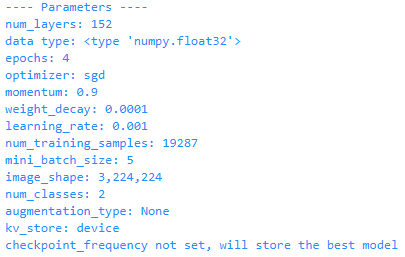

Start of training process
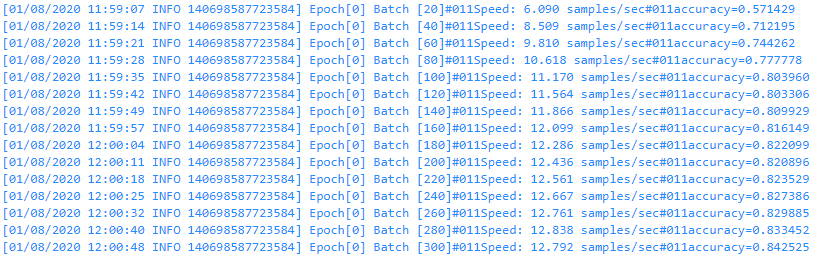

End of training process
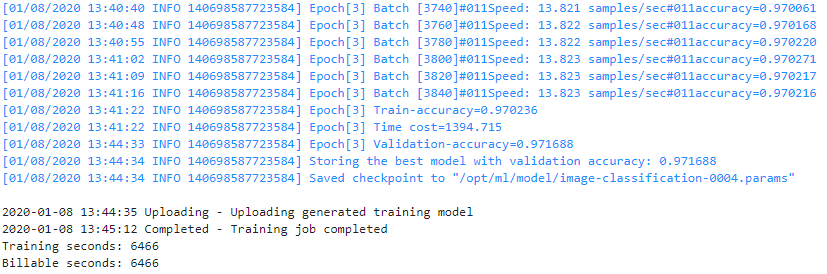

~97% accuracy was achieved<br>
Model was saved in S3 bucket as model.tar.gz file.<br>
Model can be deployed using AWS machines as it can be seen in Gabe Hollombe tutorial, link in references.<br>
I decided to deploy model on my computer.

## 4. Model deployment

Model was downloaded from S3 bucket.<br>
Model after extraction:
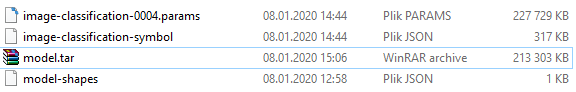
In order to deploy model locally MXNet package was used.

In [ ]:
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import namedtuple

In [ ]:
# path to extracted model and epoch number
lenet_model = mx.mod.Module.load('model/image-classification',4)
image_l = 224
image_w = 224
lenet_model.bind(for_training=False, data_shapes=[('data',(1,3,image_l,image_w))],label_shapes=lenet_model._label_shapes)

In [ ]:
Batch = namedtuple('Batch', ['data'])

def predict(name, labels):
    # convert [x, y, channels] format of jpg to [bath, channels, x, y] format required by mxnet
    img = img=mpimg.imread(name)
    img = np.array([img[:,:,0], img[:,:,1], img[:,:,2]])
    img = np.expand_dims(img, axis=0)
    
    # compute the predict probabilities
    lenet_model.forward(Batch([mx.nd.array(img)]))
    prob = lenet_model.get_outputs()[0].asnumpy()

    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]

    for i in a[0:2]:
       print('probability=%f, class=%s' %(prob[i], labels[i]))

In [ ]:
image_path = '0.jpg'

labels = ['parasitized','uninfected']
predict(image_path, labels )

image = mpimg.imread(image_path)
imgplot = plt.imshow(image)

Output:
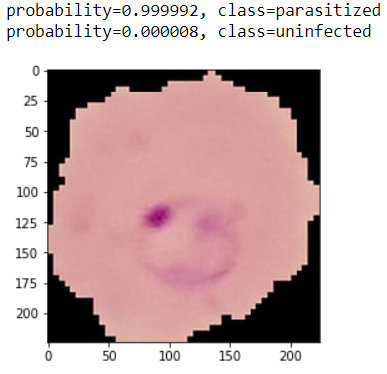

As it is much more dangerous to misclassify parasitized blood cell as uninfected one, these errors were found to take a closer look. <br>
Some blood cells labeled as parasitized by human and labeled as uninfected by model:
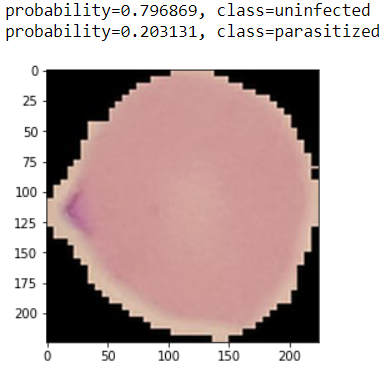
Suprising misclasification:
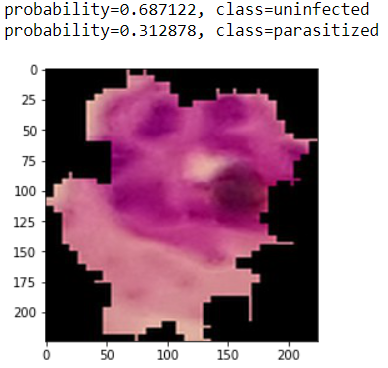
Barely visible malaria:
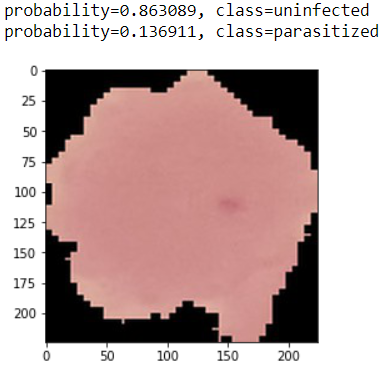
In order to reduce false negatives number, threshold should be adjusted.

## References

Most important tutorial used for this project: <br>
https://github.com/gabehollombe-aws/jupyter-notebooks/blob/master/DL%20Intro%20Demo%20-%20Sagemaker%20Image%20Classifer%20via%20Transfer%20Learning.ipynb
<br>with youtube video<br> https://www.youtube.com/watch?v=KCzgR7eQ3PY

End-to-End Multiclass Image Classification Example:<br>
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.ipynb